In [2]:
import os

# 데이터 경로 설정
train_dir = './train'
test_dir = './test'
labels_file = './labels.csv'

# 파일 확인
print(f"훈련 이미지 경로: {train_dir}")
print(f"테스트 이미지 경로: {test_dir}")
print(f"레이블 파일 경로: {labels_file}")

print("\n훈련 이미지 디렉토리 파일 예시:")
print(os.listdir(train_dir)[:5])  # 훈련 이미지 파일 목록 일부 출력

print("\n테스트 이미지 디렉토리 파일 예시:")
print(os.listdir(test_dir)[:5])  # 테스트 이미지 파일 목록 일부 출력

# 레이블 파일 확인
print("\n레이블 파일 내용 예시:")
with open(labels_file, 'r') as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:  # 처음 5줄만 출력
            break


훈련 이미지 경로: ./train
테스트 이미지 경로: ./test
레이블 파일 경로: ./labels.csv

훈련 이미지 디렉토리 파일 예시:
['53f89cf0e6bc883462dc5a147462fe37.jpg', '58ca1366de1592e48fefa05d4c833942.jpg', '94e9f738b011bc5258d0593fbd9d4bb6.jpg', '9bef849130e5759f4e77d9cdbd72034a.jpg', 'a6c40bfb565f1f99d400ed89f332db75.jpg']

테스트 이미지 디렉토리 파일 예시:
['1dbb9c899296b634dab9a43601a66a92.jpg', '6ae4fdf29e4e33b011856409dfc1b0a5.jpg', '53789615849b9f618c279670c859f61c.jpg', '12595290a6be01f4edc990edd1e69a64.jpg', '369b66c149b857c369f839c1a2840e74.jpg']

레이블 파일 내용 예시:
id,breed
000bec180eb18c7604dcecc8fe0dba07,boston_bull
001513dfcb2ffafc82cccf4d8bbaba97,dingo
001cdf01b096e06d78e9e5112d419397,pekinese
00214f311d5d2247d5dfe4fe24b2303d,bluetick
0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
import pandas as pd

# 레이블 데이터 로드
labels_df = pd.read_csv(labels_file)

# 데이터프레임의 첫 몇 줄을 출력
print("\n레이블 데이터프레임 상위 5개 행:")
print(labels_df.head())

# 데이터프레임의 기본 정보 확인
print("\n레이블 데이터프레임 정보:")
print(labels_df.info())

# 레이블 분포 확인
print("\n레이블 분포:")
print(labels_df['breed'].value_counts())



레이블 데이터프레임 상위 5개 행:
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

레이블 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None

레이블 분포:
breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Leng


샘플 이미지 크기: (500, 375)


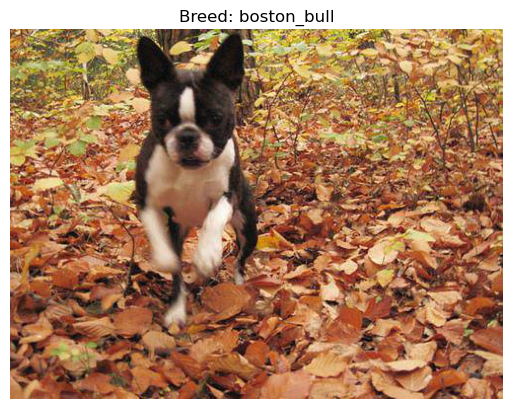

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# 예시로 첫 번째 이미지 파일 시각화
sample_image_name = os.path.join(train_dir, labels_df.iloc[0, 0] + '.jpg')

# 이미지 열기
image = Image.open(sample_image_name)
print(f"\n샘플 이미지 크기: {image.size}")

# 이미지 시각화
plt.imshow(image)
plt.title(f"Breed: {labels_df.iloc[0, 1]}")
plt.axis('off')
plt.show()


In [5]:
from torchvision import transforms

# 데이터 전처리 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지를 224x224 크기로 조정
    transforms.ToTensor(),          # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지를 정규화 (ImageNet 기준 평균 및 표준편차)
])


In [22]:
from torch.utils.data import Dataset

# 레이블 매핑 생성
breed_to_idx = {breed: idx for idx, breed in enumerate(labels_df['breed'].unique())}
idx_to_breed = {idx: breed for breed, idx in breed_to_idx.items()}


In [23]:
class DogBreedDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test  # 테스트 데이터셋 여부

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0] + '.jpg')  # 이미지 파일 경로 생성
        image = Image.open(img_name)  # 이미지 열기
        
        if not self.is_test:  # 학습/검증 데이터셋인 경우 레이블 처리
            breed_name = self.dataframe.iloc[idx, 1]  # 레이블 가져오기
            label = breed_to_idx[breed_name]  # 문자열 레이블을 숫자로 변환
        else:  # 테스트 데이터셋인 경우 레이블 없음
            label = -1  # 테스트 데이터셋의 경우 사용되지 않음
        
        if self.transform:
            image = self.transform(image)  # 전처리 적용
        
        return image, label


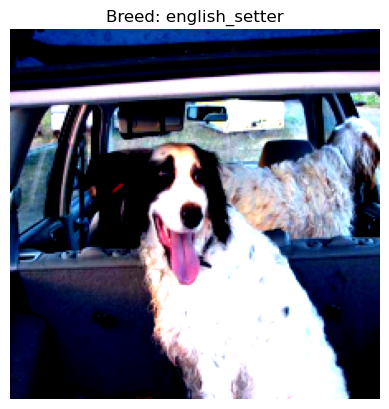

In [17]:
from torch.utils.data import DataLoader
import numpy as np

# 훈련 데이터셋 및 데이터로더 생성
train_dataset = DogBreedDataset(dataframe=labels_df, img_dir=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 배치 크기 32, 데이터 셔플링

import torch

# 비정규화 및 클리핑 함수 정의
def imshow(img, title=None):
    img = img / 2 + 0.5  # 비정규화: Normalize에서 사용된 mean과 std의 반대 연산 수행
    img = torch.clamp(img, 0, 1)  # 이미지 데이터를 [0, 1]로 클리핑
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# 데이터 로드 및 시각화 테스트
dataiter = iter(balanced_train_loader)
images, labels = next(dataiter)

# 첫 번째 이미지 시각화
imshow(images[0].cpu(), title=f"Breed: {labels[0]}")



In [18]:
from sklearn.utils import resample

# 각 클래스의 최소 이미지 수 계산
min_class_count = labels_df['breed'].value_counts().min()

# 균형 잡힌 데이터셋 생성
balanced_df = pd.DataFrame()

# 각 클래스에서 min_class_count만큼 샘플링 (랜덤 시드 설정)
random_seed = 42

for breed in labels_df['breed'].unique():
    breed_subset = labels_df[labels_df['breed'] == breed]
    balanced_breed_subset = resample(
        breed_subset, 
        replace=False, 
        n_samples=min_class_count, 
        random_state=random_seed  # 랜덤 시드 설정으로 고정된 샘플링
    )
    balanced_df = pd.concat([balanced_df, balanced_breed_subset])

print("균형 잡힌 데이터셋 크기:", balanced_df.shape)
print("균형 잡힌 데이터셋의 클래스 분포:")
print(balanced_df['breed'].value_counts())


균형 잡힌 데이터셋 크기: (7920, 2)
균형 잡힌 데이터셋의 클래스 분포:
breed
boston_bull                  66
dingo                        66
gordon_setter                66
english_foxhound             66
staffordshire_bullterrier    66
                             ..
norwegian_elkhound           66
tibetan_terrier              66
border_terrier               66
toy_poodle                   66
rottweiler                   66
Name: count, Length: 120, dtype: int64


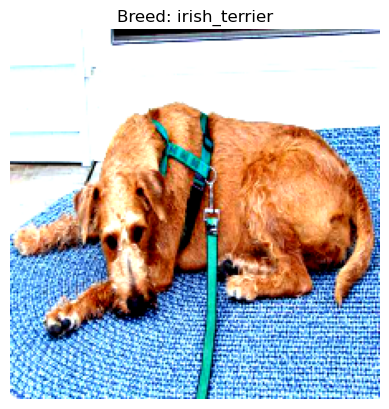

In [19]:
# 균형 잡힌 훈련 데이터셋 및 데이터로더 생성
balanced_train_dataset = DogBreedDataset(dataframe=balanced_df, img_dir=train_dir, transform=transform)
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)

# 데이터 로드 및 시각화 테스트
dataiter = iter(balanced_train_loader)
images, labels = next(dataiter)

# 첫 번째 이미지 시각화
imshow(images[0], title=f"Breed: {labels[0]}")


In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

# 사전 훈련된 ResNet 모델 로드
model = models.resnet50(pretrained=True)

# 출력층 수정: 120개의 강아지 품종 클래스에 맞게 출력층 조정
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)

# 모델을 GPU로 이동
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


/home/sdf1ai810/miniconda3/envs/module01/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sdf1ai810/miniconda3/envs/module01/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
import torch.optim as optim

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    
    for inputs, labels in balanced_train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)  # 여기서 labels를 정수형으로 변환
        
        # 옵티마이저 초기화
        optimizer.zero_grad()
        
        # Forward 패스
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward 패스 및 옵티마이저 스텝
        loss.backward()
        optimizer.step()
        
        # 손실 값 갱신
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(balanced_train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

print("모델 학습 완료!")


In [ ]:
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

# 모델 평가 모드로 전환
model.eval()

# 검증 데이터셋 준비 (현재는 학습 데이터의 일부를 사용)
val_loader = balanced_train_loader  # 실제로는 별도의 검증 데이터를 사용하는 것이 좋습니다.

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(all_labels, all_preds)
print(f'Validation Accuracy: {accuracy:.4f}')


In [ ]:
# 테스트 데이터셋 생성
test_dir = './test'  # 실제 경로를 사용하세요.
test_df = pd.DataFrame({'id': [f.split('.')[0] for f in os.listdir(test_dir)], 'breed': [''] * len(os.listdir(test_dir))})

test_dataset = DogBreedDataset(dataframe=test_df, img_dir=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 테스트 데이터에 대한 예측 수행
model.eval()
predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        predictions.extend(probabilities.cpu().numpy())

# 제출 파일 생성
predictions_df = pd.DataFrame(predictions, columns=idx_to_breed.values())
predictions_df.insert(0, 'id', test_df['id'])
predictions_df.to_csv('submission.csv', index=False)
print("제출 파일 생성 완료: submission.csv")


In [ ]:
from sklearn.model_selection import train_test_split

# 균형 잡힌 데이터셋을 훈련 데이터와 검증 데이터로 분리 (80:20 비율)
train_df, val_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['breed'], random_state=42)

print("훈련 데이터 크기:", train_df.shape)
print("검증 데이터 크기:", val_df.shape)

# 훈련 데이터셋 및 데이터로더 생성
train_dataset = DogBreedDataset(dataframe=train_df, img_dir=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 검증 데이터셋 및 데이터로더 생성
val_dataset = DogBreedDataset(dataframe=val_df, img_dir=train_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# 사전 훈련된 ResNet 모델 로드 (초기층 고정)
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in model.parameters():
    param.requires_grad = False  # 모든 파라미터를 고정

# 마지막 레이어만 학습 가능하게 설정
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 120)  # 출력층 수정
model.fc.requires_grad = True

model = model.to(device)

# 옵티마이저 및 학습률 설정 (AdamW 사용)
optimizer = optim.AdamW(model.fc.parameters(), lr=1e-4)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')
    
    # 검증 단계
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

print("모델 학습 및 검증 완료!")


In [ ]:
# 테스트 데이터셋 생성
test_df = pd.DataFrame({'id': [f.split('.')[0] for f in os.listdir(test_dir)]})

test_dataset = DogBreedDataset(dataframe=test_df, img_dir=test_dir, transform=transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 테스트 데이터에 대한 예측 수행
model.eval()
predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        predictions.extend(probabilities.cpu().numpy())

# 제출 파일 생성
predictions_df = pd.DataFrame(predictions, columns=idx_to_breed.values())
predictions_df.insert(0, 'id', test_df['id'])
predictions_df.to_csv('submission.csv', index=False)
print("제출 파일 생성 완료: submission.csv")


In [24]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# 데이터 경로 설정
train_dir = './train'
test_dir = './test'
labels_file = './labels.csv'

# 레이블 파일 읽기
labels_df = pd.read_csv(labels_file)

# 라벨 -> 인덱스, 인덱스 -> 라벨 변환
breed_to_idx = {breed: idx for idx, breed in enumerate(sorted(labels_df['breed'].unique()))}
idx_to_breed = {idx: breed for breed, idx in breed_to_idx.items()}

# 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset 클래스 정의
class DogBreedDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if not self.is_test:
            breed_name = self.dataframe.iloc[idx, 1]
            label = breed_to_idx[breed_name]
            return image, label
        else:
            return image, self.dataframe.iloc[idx, 0]

# 균형 잡힌 데이터셋 분리 8:2
balanced_df = labels_df.groupby('breed').apply(lambda x: x.sample(66)).reset_index(drop=True)
train_df, val_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['breed'], random_state=42)

# 훈련 및 검증 데이터셋 생성
train_dataset = DogBreedDataset(dataframe=train_df, img_dir=train_dir, transform=transform)
val_dataset = DogBreedDataset(dataframe=val_df, img_dir=train_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 사전 훈련된 ResNet 모델 로드 (초기층 고정)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in model.parameters():
    param.requires_grad = False  # 모든 파라미터를 고정

# 마지막 레이어만 학습 가능하게 설정
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(breed_to_idx))  # 출력층 수정 (120 클래스)
model.fc.requires_grad = True

model = model.to(device)

# 옵티마이저 및 학습률 설정 (AdamW 사용)
optimizer = optim.AdamW(model.fc.parameters(), lr=1e-4)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 모델 학습 및 검증
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')
    
    # 검증 단계
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

print("모델 학습 및 검증 완료!")

# 테스트 데이터셋 생성
test_df = pd.DataFrame({'id': [f.split('.')[0] for f in os.listdir(test_dir)]})

test_dataset = DogBreedDataset(dataframe=test_df, img_dir=test_dir, transform=transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 테스트 데이터에 대한 예측 수행
model.eval()
predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        predictions.extend(probabilities.cpu().numpy())

# 제출 파일 생성
predictions_df = pd.DataFrame(predictions, columns=idx_to_breed.values())
predictions_df.insert(0, 'id', test_df['id'])
predictions_df.to_csv('submission.csv', index=False)
print("제출 파일 생성 완료: submission.csv")


/tmp/ipykernel_28668/3674338337.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = labels_df.groupby('breed').apply(lambda x: x.sample(66)).reset_index(drop=True)


Epoch 1/10, Training Loss: 4.5142


/home/sdf1ai810/miniconda3/envs/module01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 4.2388, Accuracy: 0.4110, F1-Score: 0.3926, Precision: 0.4897, Recall: 0.4110
Epoch 2/10, Training Loss: 3.9337
Validation Loss: 3.7928, Accuracy: 0.6206, F1-Score: 0.6172, Precision: 0.6724, Recall: 0.6206
Epoch 3/10, Training Loss: 3.4465
Validation Loss: 3.3934, Accuracy: 0.7090, F1-Score: 0.7062, Precision: 0.7344, Recall: 0.7090
Epoch 4/10, Training Loss: 3.0152
Validation Loss: 3.0563, Accuracy: 0.7298, F1-Score: 0.7244, Precision: 0.7523, Recall: 0.7298
Epoch 5/10, Training Loss: 2.6403
Validation Loss: 2.7144, Accuracy: 0.7431, F1-Score: 0.7382, Precision: 0.7628, Recall: 0.7431
Epoch 6/10, Training Loss: 2.3100
Validation Loss: 2.4632, Accuracy: 0.7475, F1-Score: 0.7420, Precision: 0.7669, Recall: 0.7475
Epoch 7/10, Training Loss: 2.0264
Validation Loss: 2.2170, Accuracy: 0.7607, F1-Score: 0.7567, Precision: 0.7779, Recall: 0.7607
Epoch 8/10, Training Loss: 1.7836
Validation Loss: 2.0509, Accuracy: 0.7702, F1-Score: 0.7658, Precision: 0.7863, Recall: 0.7702
Ep

In [25]:
import numpy as np
import torch.nn.functional as F

# LIME에서 사용할 예측 함수 정의
def predict_function(images):
    images = torch.stack([transform(Image.fromarray(img)) for img in images]).to(device)
    outputs = model(images)
    return F.softmax(outputs, dim=1).cpu().detach().numpy()


In [28]:
import lime
from lime import lime_image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from PIL import Image
import cv2

# LIME 설명 생성기
explainer = lime_image.LimeImageExplainer()


In [29]:

# 이미지 설명 함수
def explain_image(image_path, model, class_names):
    # 이미지 로드 및 변환
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    
    # LIME을 사용한 설명 생성
    explanation = explainer.explain_instance(image_np, predict_function, top_labels=5, hide_color=0, num_samples=1000)
    
    # 예측된 클래스에 대한 설명 시각화
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    img_boundary = mark_boundaries(temp / 255.0, mask)
    
    # 원본 이미지와 LIME 결과 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_boundary)
    plt.title(f'LIME Explanation - Class: {class_names[explanation.top_labels[0]]}')
    plt.axis('off')

    plt.show()


100%|██████████| 1000/1000 [00:12<00:00, 79.83it/s]


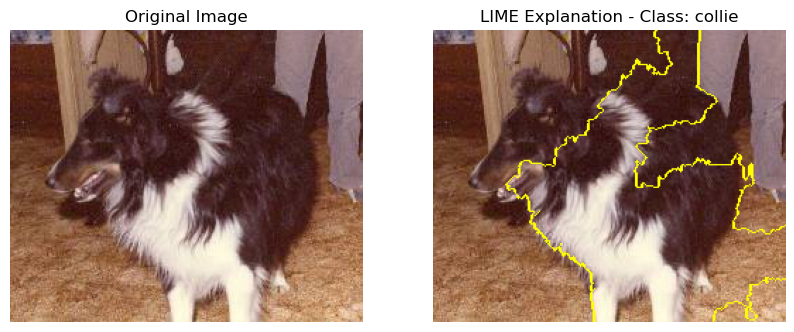

In [30]:

# 테스트 이미지 예시 경로
test_image_path = 'test/00b965deff7c711cfeaa927ce52f8653.jpg'  # 실제 테스트 이미지 경로로 변경하세요

# LIME 설명 시각화 실행
explain_image(test_image_path, model, idx_to_breed)


In [31]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import matplotlib.pyplot as plt
import copy

# 데이터 경로 설정
train_dir = './train'
test_dir = './test'
labels_file = './labels.csv'

# 레이블 파일 읽기
labels_df = pd.read_csv(labels_file)

# 라벨 -> 인덱스, 인덱스 -> 라벨 변환
breed_to_idx = {breed: idx for idx, breed in enumerate(sorted(labels_df['breed'].unique()))}
idx_to_breed = {idx: breed for breed, idx in breed_to_idx.items()}

# 데이터 전처리 (데이터 증강 포함)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset 클래스 정의
class DogBreedDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if not self.is_test:
            breed_name = self.dataframe.iloc[idx, 1]
            label = breed_to_idx[breed_name]
            return image, label
        else:
            return image, self.dataframe.iloc[idx, 0]

# 균형 잡힌 데이터셋 분리
balanced_df = labels_df.groupby('breed').apply(lambda x: x.sample(66)).reset_index(drop=True)
train_df, val_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['breed'], random_state=42)

# 훈련 및 검증 데이터셋 생성
train_dataset = DogBreedDataset(dataframe=train_df, img_dir=train_dir, transform=train_transform)
val_dataset = DogBreedDataset(dataframe=val_df, img_dir=train_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 사전 훈련된 ResNet 모델 로드 (전체 미세조정)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(breed_to_idx))
model = model.to(device)

# 모든 파라미터를 학습 가능하게 설정
for param in model.parameters():
    param.requires_grad = True

# 옵티마이저 및 스케줄러 설정
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# 조기 종료를 위한 변수
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
early_stop_count = 0
early_stop_limit = 3  # 조기 종료 한계 (연속 에포크 동안 성능 향상이 없을 시)
best_model_path = 'best_model.pth'

# 손실 함수
criterion = nn.CrossEntropyLoss()

# 모델 학습 및 검증
num_epochs = 20
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # 학습 단계
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Training Loss: {epoch_loss:.4f}')
    
    # 검증 단계
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    # 조기 종료 조건 체크 및 베스트 모델 저장
    if accuracy > best_acc:
        best_acc = accuracy
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_count = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}')

    else:
        early_stop_count += 1
    
    # 학습률 스케줄러 업데이트
    scheduler.step()
    
    # 조기 종료 체크
    if early_stop_count >= early_stop_limit:
        print("Early stopping triggered")
        break

# 최적의 모델 가중치 로드
model.load_state_dict(best_model_wts)
print(f'Best Validation Accuracy: {best_acc:.4f}')

# 테스트 데이터셋 생성
test_df = pd.DataFrame({'id': [f.split('.')[0] for f in os.listdir(test_dir)]})

test_dataset = DogBreedDataset(dataframe=test_df, img_dir=test_dir, transform=val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 테스트 데이터에 대한 예측 수행
model.eval()
predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        predictions.extend(probabilities.cpu().numpy())

# 제출 파일 생성
predictions_df = pd.DataFrame(predictions, columns=idx_to_breed.values())
predictions_df.insert(0, 'id', test_df['id'])
predictions_df.to_csv('submission.csv', index=False)
print("제출 파일 생성 완료: submission.csv")


/tmp/ipykernel_28668/811190439.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = labels_df.groupby('breed').apply(lambda x: x.sample(66)).reset_index(drop=True)


Epoch 1/20
Training Loss: 3.4007


/home/sdf1ai810/miniconda3/envs/module01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 1.1687, Accuracy: 0.7191, F1-Score: 0.6997, Precision: 0.7349, Recall: 0.7191
Epoch 2/20
Training Loss: 1.5967


/home/sdf1ai810/miniconda3/envs/module01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 0.8369, Accuracy: 0.7569, F1-Score: 0.7491, Precision: 0.7747, Recall: 0.7569
Epoch 3/20
Training Loss: 1.2194


/home/sdf1ai810/miniconda3/envs/module01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 0.7496, Accuracy: 0.7816, F1-Score: 0.7748, Precision: 0.8022, Recall: 0.7816
Epoch 4/20
Training Loss: 1.1350
Validation Loss: 0.7450, Accuracy: 0.7955, F1-Score: 0.7922, Precision: 0.8109, Recall: 0.7955
Epoch 5/20
Training Loss: 1.0311
Validation Loss: 0.6824, Accuracy: 0.7936, F1-Score: 0.7902, Precision: 0.8066, Recall: 0.7936
Epoch 6/20
Training Loss: 0.8526
Validation Loss: 0.6167, Accuracy: 0.8157, F1-Score: 0.8120, Precision: 0.8226, Recall: 0.8157
Epoch 7/20
Training Loss: 0.8110
Validation Loss: 0.5981, Accuracy: 0.8283, F1-Score: 0.8249, Precision: 0.8347, Recall: 0.8283
Epoch 8/20
Training Loss: 0.7695
Validation Loss: 0.5830, Accuracy: 0.8295, F1-Score: 0.8262, Precision: 0.8351, Recall: 0.8295
Epoch 9/20
Training Loss: 0.7630
Validation Loss: 0.5874, Accuracy: 0.8245, F1-Score: 0.8214, Precision: 0.8315, Recall: 0.8245
Epoch 10/20
Training Loss: 0.7500
Validation Loss: 0.5776, Accuracy: 0.8270, F1-Score: 0.8244, Precision: 0.8333, Recall: 0.8270
Epoch 11

In [33]:
torch.save(best_model_wts, "best_model_2.pth")

/tmp/ipykernel_28668/1994420753.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_2.pth"))
100%|██████████| 1000/1000 [00:25<

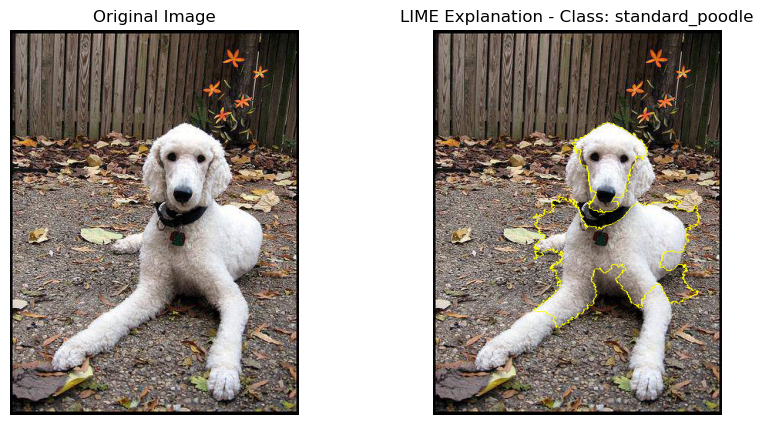

In [35]:
import lime
from lime import lime_image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from PIL import Image
import cv2

# LIME 설명 생성기
explainer = lime_image.LimeImageExplainer()
model.load_state_dict(torch.load("best_model_2.pth"))


# 이미지 설명 함수
def explain_image(image_path, model, class_names):
    # 이미지 로드 및 변환
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    
    # LIME을 사용한 설명 생성
    explanation = explainer.explain_instance(image_np, predict_function, top_labels=5, hide_color=0, num_samples=1000)
    
    # 예측된 클래스에 대한 설명 시각화
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    img_boundary = mark_boundaries(temp / 255.0, mask)
    
    # 원본 이미지와 LIME 결과 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_boundary)
    plt.title(f'LIME Explanation - Class: {class_names[explanation.top_labels[0]]}')
    plt.axis('off')
    plt.show()


# 테스트 이미지 예시 경로
test_image_path = 'test/ff2ff9ee8fcf6085d7aa194f8f3f5673.jpg'  # 실제 테스트 이미지 경로로 변경하세요

# LIME 설명 시각화 실행
explain_image(test_image_path, model, idx_to_breed)


In [36]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import copy

# 데이터 경로 설정
train_dir = './train'
test_dir = './test'
labels_file = './labels.csv'

# 레이블 파일 읽기
labels_df = pd.read_csv(labels_file)

# 라벨 -> 인덱스, 인덱스 -> 라벨 변환
breed_to_idx = {breed: idx for idx, breed in enumerate(sorted(labels_df['breed'].unique()))}
idx_to_breed = {idx: breed for breed, idx in breed_to_idx.items()}

# 데이터 전처리 (데이터 증강 포함)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset 클래스 정의
class DogBreedDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if not self.is_test:
            breed_name = self.dataframe.iloc[idx, 1]
            label = breed_to_idx[breed_name]
            return image, label
        else:
            return image, self.dataframe.iloc[idx, 0]

# 데이터셋 분리 (샘플링 제거, 전체 데이터 사용)
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['breed'], random_state=42)

# 훈련 및 검증 데이터셋 생성
train_dataset = DogBreedDataset(dataframe=train_df, img_dir=train_dir, transform=train_transform)
val_dataset = DogBreedDataset(dataframe=val_df, img_dir=train_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(labels_df['breed']), y=labels_df['breed'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 사전 훈련된 ResNet 모델 로드 (전체 미세조정)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(breed_to_idx))
model = model.to(device)

# 모든 파라미터를 학습 가능하게 설정
for param in model.parameters():
    param.requires_grad = True

# 옵티마이저 및 OneCycleLR 스케줄러 설정
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=20)

# 손실 함수 (클래스 가중치 적용)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# 조기 종료 및 모델 저장 관련 설정
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
early_stop_count = 0
early_stop_limit = 3  # 조기 종료 한계
best_model_path = 'best_model_3.pth'

# 모델 학습 및 검증
num_epochs = 20
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # 학습 단계
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Training Loss: {epoch_loss:.4f}')
    
    # 검증 단계
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    # 조기 종료 조건 체크 및 베스트 모델 저장
    if accuracy > best_acc:
        best_acc = accuracy
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_count = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}')

    else:
        early_stop_count += 1
    
    # 조기 종료 체크
    if early_stop_count >= early_stop_limit:
        print("Early stopping triggered")
        break

# 최적의 모델 가중치 로드
model.load_state_dict(best_model_wts)
print(f'Best Validation Accuracy: {best_acc:.4f}')

# 테스트 데이터셋 생성
test_df = pd.DataFrame({'id': [f.split('.')[0] for f in os.listdir(test_dir)]})

test_dataset = DogBreedDataset(dataframe=test_df, img_dir=test_dir, transform=val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 테스트 데이터에 대한 예측 수행
model.eval()
predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        predictions.extend(probabilities.cpu().numpy())

# 제출 파일 생성
predictions_df = pd.DataFrame(predictions, columns=idx_to_breed.values())
predictions_df.insert(0, 'id', test_df['id'])
predictions_df.to_csv('submission_3.csv', index=False)
print("제출 파일 생성 완료: submission_3.csv")


Epoch 1/20
Training Loss: 3.8747
Validation Loss: 1.3771, Accuracy: 0.7262, F1-Score: 0.7095, Precision: 0.7898, Recall: 0.7262
Best model saved at epoch 1 with validation loss: 1.3771
Epoch 2/20
Training Loss: 1.7528
Validation Loss: 1.0842, Accuracy: 0.6836, F1-Score: 0.6726, Precision: 0.7314, Recall: 0.6836
Epoch 3/20
Training Loss: 1.8806


/home/sdf1ai810/miniconda3/envs/module01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 1.7974, Accuracy: 0.5291, F1-Score: 0.5073, Precision: 0.6278, Recall: 0.5291
Epoch 4/20
Training Loss: 2.0995


/home/sdf1ai810/miniconda3/envs/module01/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 2.7311, Accuracy: 0.3384, F1-Score: 0.3371, Precision: 0.4958, Recall: 0.3384
Early stopping triggered
Best Validation Accuracy: 0.7262
제출 파일 생성 완료: submission_3.csv
